In [1]:
import torch

from transformers import PreTrainedModel
from trader_models import SRUTrader, SRUConfig, SGConvConfig, SGConvTrader
from datasets import load_dataset, Dataset, DatasetDict

from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

import numpy as np

import logging
logging.disable(logging.INFO)

In [2]:
def compute_metrics(preds):
    soft_profit, soft_trade = preds.predictions
    abs_trade = np.abs(soft_trade)
    abs_trade = abs_trade.astype('float64') # half precision will cause the sum to overflow on next line
    trades = abs_trade.sum()
    
    day_profits = soft_profit.sum(axis = (1, 2))
    
    metrics = {
        'day profit': day_profits.mean(),
        'day sharpe': day_profits.mean() / day_profits.std(),
        'trade %': trades * 100 / soft_profit.size,
        
        'full trade %': (abs_trade >= .7).mean() * 100,
        'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
        'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
                          / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
        
        'medium trade %': ((abs_trade < .7) & (abs_trade >= .4)).mean() * 100,
        'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
        'medium trade g/l': soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),       
        
        'small trade %': ((abs_trade < .4) & (abs_trade >= .2)).mean() * 100,
        'small trade accuracy': (soft_profit[(abs_trade < .4) & (abs_trade >= .2)] > 0).mean() * 100,
        'small trade g/l': soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit > 0)].mean()
                            / -soft_profit[(abs_trade < .4) & (abs_trade >= .2) & (soft_profit < 0)].mean(),        
    }
    
    # round the metrics
    metrics = {k: np.format_float_positional(v, precision = 4) for k, v in metrics.items()}
    
    return metrics

In [3]:
# fx = Dataset.load_from_disk('data/firstrate_days.ds')

# # make splits
# split = fx.train_test_split(.003, shuffle = False)
# valid_test = split['test'].train_test_split(.3, shuffle = False)
# fx = DatasetDict({
#     'train': split['train'],
#     'validation': valid_test['train'],
#     'test': valid_test['test']
# })

In [4]:
fx = Dataset.load_from_disk('data/fx_days.ds')

# make splits
split = fx.train_test_split(.003, shuffle = False)
valid_test = split['test'].train_test_split(.3, shuffle = False)
fx = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [5]:
fx

DatasetDict({
    train: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 35213
    })
    validation: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 74
    })
    test: Dataset({
        features: ['ohlcv', 'labels', 'future'],
        num_rows: 32
    })
})

In [6]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 200,
    eval_steps = 200,
    save_steps = 10000,
    report_to = "none",
    learning_rate = 1e-4,
    weight_decay = .01,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size = 2,
    max_grad_norm = 1,
    fp16 = True,
)

In [7]:
config = SRUConfig(
    n_embd = 320, n_head = 5 * 4, hidden_dropout_prob = 0
)

model = SRUTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

In [8]:
# OANDA finnhub, only from 2009 and only top 10 majors, no volume (to be similar to firstrate) only close and close diff

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, NO rotary embed, norm or resid on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.258100,2.193474,0.0286,0.1659,6.5116,0.0011,54.5455,0.6186,0.0422,16.0494,0.9636,2.2643,39.3212,1.0759
400,2.201800,2.185424,-0.0262,-0.0771,8.3077,0.0705,0.8876,0.7036,1.2364,5.4984,0.9971,5.7961,47.1297,1.0493
600,2.197600,2.188328,0.0085,0.0461,7.0410,0.3534,0.0590,0.669,1.0052,4.471,1.0310,1.5475,43.7976,1.1308
800,2.200600,2.195617,0.0774,0.1689,14.1673,0.2401,0.5645,0.1081,0.2044,4.7959,1.0865,20.0892,52.0297,1.0338
1000,2.189900,2.176386,0.0296,0.1973,6.1384,0.8275,0.,nan,0.2601,2.0048,1.5603,0.6841,44.0634,1.0551
1200,2.171200,2.175950,-0.0379,-0.1197,9.1543,1.0965,0.1141,0.5855,0.1939,6.5054,1.1612,5.2620,47.3655,0.9768
1400,2.178900,2.174093,0.0205,0.2667,6.5266,1.2283,0.0255,0.2098,0.1671,3.8677,0.7396,0.5219,46.3337,0.9322
1600,2.172600,2.178842,0.0491,0.2416,8.4848,1.4084,0.6293,2.8776,0.0882,11.8203,0.808,1.8730,55.8481,1.0201
1800,2.169400,2.166808,0.0158,0.1579,7.9401,1.4970,0.3065,1.0143,0.0508,17.8645,0.845,1.9651,52.8706,0.9855
2000,2.178600,2.168239,0.0413,0.3022,7.1867,1.3680,0.,nan,0.078,1.4706,0.4641,0.4402,49.6447,0.9459


<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


TrainOutput(global_step=17607, training_loss=2.155581929556805, metrics={'train_runtime': 5580.8579, 'train_samples_per_second': 6.31, 'train_steps_per_second': 3.155, 'total_flos': 0.0, 'train_loss': 2.155581929556805, 'epoch': 1.0})

In [9]:
trainer.evaluate(fx['test'])

{'eval_loss': 2.12296199798584,
 'eval_day profit': '0.045',
 'eval_day sharpe': '0.4100',
 'eval_trade %': '7.7770',
 'eval_full trade %': '1.8586',
 'eval_full trade accuracy': '2.4261',
 'eval_full trade g/l': '2.2313',
 'eval_medium trade %': '0.9469',
 'eval_medium trade accuracy': '70.1299',
 'eval_medium trade g/l': '1.9277',
 'eval_small trade %': '2.7433',
 'eval_small trade accuracy': '62.3275',
 'eval_small trade g/l': '1.1338',
 'eval_runtime': 2.6188,
 'eval_samples_per_second': 12.219,
 'eval_steps_per_second': 6.11,
 'epoch': 1.0}

In [10]:
trainer.save_model('srupp.model')

# quick prediction test to ensure model isn't cheating

In [11]:
model = SRUTrader.from_pretrained('srupp.model', config = config).cuda().eval()

0
tensor([ 8.,  5.,  5.,  5.,  6.,  8.,  7., 11., 11.])


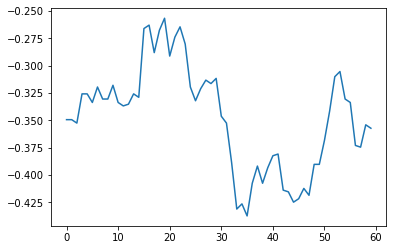

1
tensor([4., 2., 1., 3., 3., 2., 4., 5., 6.])


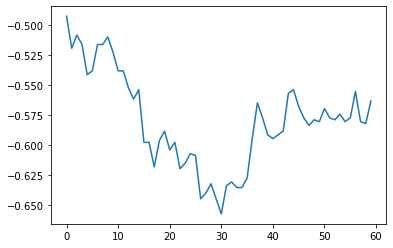

2
tensor([15., 13., 12., 12., 11., 10.,  9., 10.,  9.])


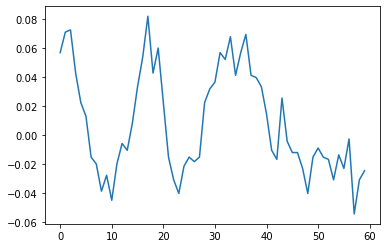

3
tensor([1., -0., -0., 1., 2., 1., 1., 2., 4.])


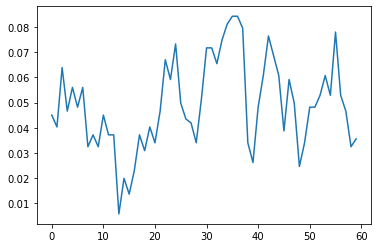

In [12]:
import matplotlib.pyplot as plt

for day in range(4):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:]).unsqueeze(0).cuda()
    test_futures = torch.tensor(fx['validation']['future'][day][:]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][2*60:3*60])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][2*60]
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

0
tensor([ 8.,  5.,  5.,  5.,  6.,  8.,  7., 11., 11.])


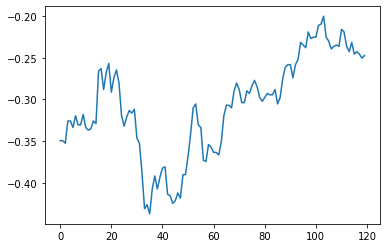

1
tensor([4., 2., 1., 3., 3., 2., 4., 5., 6.])


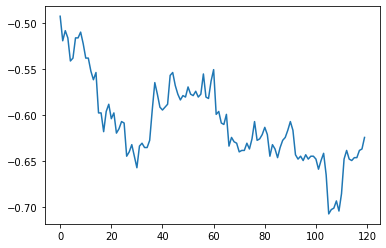

2
tensor([15., 13., 12., 12., 11., 10.,  9., 10.,  9.])


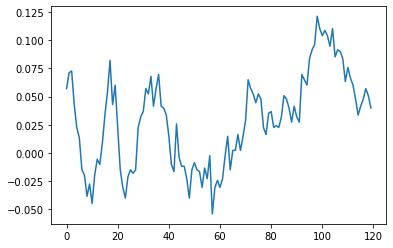

3
tensor([1., -0., -0., 1., 2., 1., 1., 2., 4.])


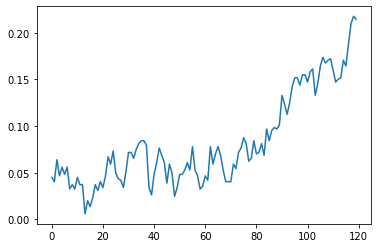

In [14]:
import matplotlib.pyplot as plt

for day in range(4):
    # cut data short so no backwards flow of info
    test_day = torch.tensor(fx['validation']['ohlcv'][day][:121]).unsqueeze(0).cuda()
    after = torch.tensor(fx['validation']['ohlcv'][day][120:240])
    with torch.no_grad():
        # no access to futures
        pred = model(test_day)[0][120]
        
    torch.cuda.empty_cache()
#     if (pred.abs() >= .9).any():
    if True:
        print(day)
#         plt.pcolormesh(pred.cpu().unsqueeze(0))
        plt.show()
        print((pred.cpu() * 100).round())
        
        plt.plot(after.select(dim = 1, index = -1))
        plt.show()

# TODO: graph these instead of showing raw data (maybe even on same plot or at least side by side)

In [15]:
soft_profit, soft_trade = trainer.predict(fx['validation']).predictions

In [16]:
(soft_profit.sum(axis = (1, 2)) < 0).mean()

0.36486486486486486

In [17]:
soft_profit.sum(axis = (1, 2)).std()

0.08853438

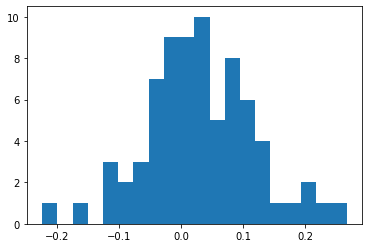

In [18]:
import matplotlib.pyplot as plt

plt.hist(soft_profit.sum(axis = (1, 2)), bins = 20)
plt.show()

In [19]:
# full trade percent on 24 hours, ignoring last hour, it makes most trades in london and ny sessions (esp overlap)
((np.abs(soft_trade) > .2).mean(axis = (0, 2)).reshape(-1, 60).mean(axis = 1) * 100).round()

array([ 1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 47., 63., 30.])

In [20]:
# full trade accuracy on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-20-1ac9a154e44f>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit > 0, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.49909872, 0.56307941, 0.50657518, 0.19721548])

In [21]:
# full trade profit on 24 hours
np.nanmean(np.where(np.abs(soft_trade) > .3, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)

<ipython-input-21-b1a53ae86831>:2: RuntimeWarning: Mean of empty slice
  np.nanmean(np.where(np.abs(soft_trade) > .3, soft_profit, np.nan), axis = (0, 2)).reshape(-1, 60).mean(axis = 1)


array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan, 5.8730193e-06, 6.4541244e-05, 7.6953938e-06],
      dtype=float32)

In [22]:
# percent full trades on all timeframes
(np.abs(soft_trade) > .2).mean(axis = (0, 1))

array([0.04648086, 0.05411036, 0.05850225, 0.06303491, 0.06889077,
       0.07491554, 0.07476539, 0.06384197, 0.05048799])

In [23]:
# full trade accuracy on all timeframes
np.nanmean(np.where(np.abs(soft_trade) > .2, soft_profit > 0, np.nan), axis = (0, 1))

array([0.37633757, 0.44103365, 0.47273019, 0.50498735, 0.52581392,
       0.52223475, 0.51186143, 0.44700867, 0.38754647])

In [24]:
# full trade gain on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit > 0), soft_profit, np.nan), axis = (0, 1))

array([8.12292492e-05, 1.01473204e-04, 1.15278272e-04, 1.22520345e-04,
       1.32214962e-04, 1.40028264e-04, 1.68057697e-04, 2.00559676e-04,
       2.91359669e-04], dtype=float32)

In [25]:
# full trade loss on all timeframes
np.nanmean(np.where((np.abs(soft_trade) > .3) & (soft_profit < 0), soft_profit, np.nan), axis = (0, 1))

array([-4.76083405e-05, -6.22327861e-05, -6.94265182e-05, -7.35067224e-05,
       -8.38432024e-05, -9.17941215e-05, -1.03077306e-04, -1.05229068e-04,
       -1.17557916e-04], dtype=float32)

In [25]:
# del trainer
# del model
# torch.cuda.empty_cache()

# Appendix

## SRU experiments

In [8]:
config = SGConvConfig(
    n_embd = 1024, n_head = 5 * 4, hidden_dropout_prob = 0
)

model = SGConvTrader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

Using 34 layers


In [9]:
# firstrate data no volume

# SGCONV! lr of 1e-3, batch size 8 hidden size 1024,
# fp16, NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.254200,2.231734,0.0738,0.4064,6.3818,0.1158,50.6751,1.8062,0.8853,46.5371,1.2629,2.5954,50.2792,1.1951
400,2.215000,2.218014,0.1326,0.6485,8.1351,0.0220,63.0332,4.7094,0.1241,61.0924,2.8094,4.3714,60.5014,1.1996
600,2.222800,2.258496,0.0758,0.4278,7.2867,0.0571,37.2263,2.3042,0.1967,53.6585,1.6169,2.6964,57.7572,1.1863
800,2.199000,2.211952,0.0805,1.0515,6.3457,0.0072,57.9710,3.3084,0.0544,45.7854,2.4971,2.0552,61.583,1.2458
1000,2.216700,2.220958,0.1141,0.5813,7.2691,0.0266,61.1765,2.9638,0.092,65.5329,2.1350,2.2743,64.3804,1.3098
1200,2.192300,2.221125,0.1514,0.7927,8.7405,0.0356,63.3431,0.7091,0.1928,55.6517,2.5370,7.5028,58.4963,1.5
1400,2.208700,2.215595,0.113,0.8174,8.2134,0.0156,68.6667,3.4398,0.0760,72.5652,2.0032,4.9196,59.9245,1.4295
1600,2.187200,2.206578,0.1646,0.8054,7.8332,0.0199,71.2042,3.3337,0.0790,72.6913,2.9198,3.6575,65.6926,1.6473
1800,2.186400,2.216811,0.2254,0.9628,14.7438,0.0186,76.4045,4.0391,1.6878,62.4699,1.4770,28.2683,55.9966,1.2313
2000,2.199600,2.203983,0.225,1.1874,10.4436,0.0203,69.2308,3.7514,0.3206,54.4065,2.2544,11.8138,60.9935,1.4159


TrainOutput(global_step=4370, training_loss=2.1916934853560317, metrics={'train_runtime': 4517.9523, 'train_samples_per_second': 7.738, 'train_steps_per_second': 0.967, 'total_flos': 0.0, 'train_loss': 2.1916934853560317, 'epoch': 1.0})

In [9]:
# OANDA finnhub data no volume

# SGCONV! lr of 1e-3, batch size 8 hidden size 1024,
# fp16, NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.220000,2.187652,-0.031,-0.1425,6.4645,0.0030,24.1379,0.3601,0.2179,29.2344,0.557,2.1444,40.2363,0.8548
400,2.190100,2.198269,-0.0177,-0.1158,5.4631,0.0001,0.,nan,0.016,37.2549,0.5714,0.8951,46.3537,0.6796
600,2.187100,2.180087,-0.0059,-0.0326,5.6219,0.0033,15.625,1.2553,0.2038,32.6854,0.6072,1.8546,46.8683,0.8487
800,2.181000,2.179209,0.0215,0.2072,6.1098,0.0001,0.,nan,0.4613,43.8517,0.5461,4.7949,52.7368,0.9696
1000,2.180400,2.184720,0.0061,0.0392,5.4193,0.0043,24.3902,0.4179,0.038,49.4505,0.7933,2.0929,56.6610,0.7902
1200,2.177600,2.178763,0.0269,0.1851,5.6066,0.0002,50.,0.1297,0.095,45.2250,0.7581,1.9855,49.0495,0.9744
1400,2.180300,2.183460,0.017,0.1776,6.0035,0.0003,33.3333,0.2226,0.0474,75.1648,0.7444,2.7303,60.2864,0.9349
1600,2.175100,2.179679,-0.0025,-0.0264,5.4435,0.,nan,nan,0.1473,40.2689,0.3282,2.3318,49.1616,0.9353
1800,2.175600,2.178945,0.0166,0.1985,4.8669,0.,nan,nan,0.3218,47.0188,0.7521,1.7703,52.5680,0.9509
2000,2.177700,2.178137,0.0297,0.2469,6.0138,0.0015,50.,0.1381,0.1581,46.504,0.5508,3.3165,52.1363,0.9324


<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


TrainOutput(global_step=4407, training_loss=2.176770738931045, metrics={'train_runtime': 4274.2353, 'train_samples_per_second': 8.248, 'train_steps_per_second': 1.031, 'total_flos': 0.0, 'train_loss': 2.176770738931045, 'epoch': 1.0})

In [9]:
# OANDA finnhub data no volume

# SGCONV! lr of 1e-3, batch size 8 hidden size 512,
# fp16, NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.227400,2.188564,-0.0206,-0.1159,5.6270,0.0003,66.6667,0.4501,0.0717,25.4360,0.4706,1.2853,37.6572,0.8081
400,2.189500,2.195636,-0.0163,-0.0995,5.1954,0.,nan,nan,0.0142,35.2941,0.5145,0.9782,44.0891,0.7485
600,2.181500,2.182680,-0.0103,-0.0543,5.6947,0.0045,18.6047,0.3742,0.1315,34.6550,0.8360,1.7467,47.4869,0.8045
800,2.180100,2.180270,0.0161,0.1732,5.6727,0.,nan,nan,0.0533,33.2681,0.313,3.3532,52.3617,0.9107
1000,2.178900,2.184605,-0.0005,-0.003,5.5146,0.0046,25.,0.5593,0.0457,54.1096,0.7466,1.8253,58.2348,0.7710
1200,2.176800,2.180275,0.0207,0.1499,5.6542,0.0005,40.,0.1338,0.0670,41.0575,0.6331,2.1548,47.6022,0.9732
1400,2.179800,2.184742,0.0140,0.1604,5.5228,0.,nan,nan,0.0227,86.6972,0.4913,1.9391,60.5313,0.8973
1600,2.175400,2.180443,-0.0003,-0.0034,5.2729,0.,nan,nan,0.1116,36.3551,0.3165,2.3695,50.1628,0.9041
1800,2.175700,2.178481,0.0163,0.2107,4.757,0.,nan,nan,0.0971,47.6907,0.5832,1.6609,53.5878,0.867
2000,2.177600,2.178528,0.0263,0.2383,5.9153,0.002,63.1579,0.1797,0.0831,56.7127,0.5402,3.2639,51.8753,0.9301


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


KeyboardInterrupt: 

In [9]:
# OANDA finnhub data no volume

# SGCONV! lr of 1e-3, batch size 8 hidden size 320,
# fp16, NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.232700,2.195208,0.0014,0.0168,4.5811,0.0001,0.,nan,0.0040,60.,2.2225,0.3617,42.7571,1.1114
400,2.194400,2.188654,0.0018,0.021,5.1786,0.0001,0.,nan,0.0916,29.5597,0.3414,1.6661,40.4783,0.6777
600,2.186300,2.186910,0.0039,0.0613,4.1490,0.,nan,nan,0.0115,46.,0.2779,0.8453,41.4850,0.5658
800,2.182300,2.181452,0.0138,0.1231,5.0521,0.0006,20.,0.1284,0.0085,29.7297,0.2408,1.2248,56.0696,0.7624
1000,2.185100,2.189359,-0.0144,-0.1099,5.8305,0.0043,10.8108,0.2840,0.2177,33.0688,0.3394,2.4124,43.8535,0.7403
1200,2.180200,2.185004,0.0094,0.1045,4.8414,0.0026,21.7391,0.3164,0.0579,48.7078,1.3516,1.5452,47.3951,0.8241
1400,2.180700,2.186272,-0.0017,-0.0220,5.4116,0.0002,50.,0.1280,0.2699,38.2253,0.4572,2.3795,46.3072,0.8331
1600,2.182900,2.179692,0.0178,0.1343,6.1707,0.,nan,nan,0.0665,37.7816,0.416,2.837,53.8768,0.8557
1800,2.180900,2.183378,-0.001,-0.0139,5.0281,0.0001,0.,nan,0.1330,38.5281,0.4297,2.3575,49.8412,0.8325


<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


KeyboardInterrupt: 

In [9]:
# firstrate data no volume

# SGCONV! lr of 1e-3, batch size 8 hidden size 320,
# fp16, NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, or norm on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.271000,2.230693,0.0614,0.3721,5.7062,0.0078,65.3333,4.3685,0.09,63.0359,1.4701,1.7201,59.8509,1.1555
400,2.217600,2.225278,0.0926,0.6827,6.4037,0.0107,69.9029,5.5255,0.0667,66.5625,1.7779,1.4557,57.6463,1.3213
600,2.207200,2.241364,0.0573,0.5304,5.1940,0.0035,58.8235,9.3187,0.0589,42.8319,3.1488,0.7115,53.8834,1.4850
800,2.197700,2.210183,0.0892,0.8594,6.5144,0.0029,53.5714,6.5159,0.0312,54.1806,3.8670,1.7302,59.6215,1.396
1000,2.205000,2.213922,0.1010,0.6076,6.9463,0.0107,66.9903,5.4746,0.041,70.2290,3.1549,1.0588,60.5082,1.4909
1200,2.190200,2.215203,0.1577,1.0051,9.7561,0.0098,60.6383,6.6245,0.0613,54.4218,3.1242,9.8843,58.8149,1.3665
1400,2.196600,2.210343,0.1259,1.0800,7.3453,0.0230,72.3982,3.549,0.0527,72.2772,2.3376,2.7651,59.9706,1.4347
1600,2.188700,2.209135,0.1739,0.8220,9.6679,0.0249,74.8954,3.3733,0.0832,64.6617,3.0852,7.6354,61.2657,1.4929
1800,2.188000,2.213350,0.1741,1.1639,10.6311,0.0198,72.1053,3.5221,0.1497,63.7187,1.4271,14.3504,58.6837,1.2741
2000,2.193700,2.205798,0.2006,1.2266,10.3597,0.0224,75.3488,3.3845,0.2082,51.1768,2.4396,12.3673,59.6027,1.3792


TrainOutput(global_step=4370, training_loss=2.1917871401020808, metrics={'train_runtime': 1567.6106, 'train_samples_per_second': 22.3, 'train_steps_per_second': 2.788, 'total_flos': 0.0, 'train_loss': 2.1917871401020808, 'epoch': 1.0})

In [9]:
# firstrate data no volume

# SGCONV! lr of 1e-3, batch size 8 hidden size 320,
# fp16, NO dropout, weight decay
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.264900,2.229113,0.0584,0.6311,4.9520,0.0026,76.,2.5136,0.0279,60.0746,2.3828,0.7740,59.1675,1.2146
400,2.211900,2.217265,0.1127,0.8401,7.2526,0.0122,65.812,5.7062,0.0559,64.7388,2.5893,1.8538,59.2947,1.2525
600,2.203300,2.227097,0.058,0.4592,5.5918,0.0031,63.3333,7.3884,0.0322,62.1359,2.7424,0.4416,57.7096,1.5507
800,2.193900,2.209114,0.1030,0.97,7.3735,0.0024,56.5217,4.2156,0.0291,55.914,4.9033,4.0070,59.057,1.4891
1000,2.199400,2.211903,0.1157,0.6121,8.0036,0.0119,64.9123,5.9017,0.0341,74.0061,2.5981,2.0531,63.7532,1.3343
1200,2.187500,2.219035,0.1861,0.8958,12.1946,0.0091,42.5287,9.5385,0.2964,61.3085,2.1953,21.5696,56.4234,1.3265
1400,2.194300,2.208715,0.1192,0.8761,7.7654,0.0204,72.9592,3.71,0.0670,69.0513,1.8592,3.4253,58.9315,1.4020
1600,2.186700,2.206259,0.1644,0.7964,9.3841,0.0234,72.3214,3.8677,0.0761,64.3836,2.9664,7.1413,61.1348,1.4599
1800,2.186300,2.207227,0.1762,1.3044,11.0333,0.0171,71.9512,3.8237,0.2659,51.2549,2.2243,15.9507,57.5686,1.3904
2000,2.192000,2.202816,0.1925,1.2530,10.0022,0.0184,69.3182,4.0807,0.2779,47.8049,2.2724,10.9574,59.8643,1.4378


KeyboardInterrupt: 

In [9]:
# firstrate data no volume

# SGCONV! lr of 7e-4, batch size 8 hidden size 320,
# fp16, NO dropout, weight decay,
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.268200,2.239735,0.0620,0.988,4.6885,0.0057,69.0909,3.2635,0.0448,67.2093,1.6570,0.6962,59.3230,1.1182
400,2.215000,2.218279,0.1009,0.7048,5.8088,0.0131,70.6349,4.9675,0.0470,72.5055,3.2190,0.913,60.9068,1.6044
600,2.207300,2.230922,0.0622,0.4952,5.3525,0.0052,56.0000,8.3060,0.0572,56.6485,3.4767,0.6537,55.1125,1.3348
800,2.196200,2.208523,0.0909,0.913,5.8864,0.0032,54.8387,6.9334,0.0338,67.9012,3.4866,0.9249,60.7892,1.5586
1000,2.201700,2.212023,0.1134,0.6804,7.4853,0.0136,73.8462,5.0778,0.0428,67.3171,3.0497,2.2404,61.7798,1.1547
1200,2.188200,2.213837,0.1479,0.9606,9.8281,0.0116,63.964,5.9025,0.0672,61.1801,3.0235,11.1763,58.8497,1.3592
1400,2.195400,2.209037,0.1199,0.7991,7.4521,0.0211,71.7822,3.7082,0.0542,69.6154,2.3321,2.9434,60.7553,1.4525
1600,2.187400,2.206240,0.1658,0.7796,9.4529,0.0244,73.0769,3.2652,0.0710,70.4846,3.1809,7.8769,61.328,1.4181
1800,2.187200,2.208302,0.1550,1.2654,9.1741,0.0217,75.9615,3.3266,0.0615,60.,2.8277,9.1404,59.4855,1.4076
2000,2.193700,2.203616,0.1894,1.1746,9.7183,0.0223,74.7664,3.3666,0.1148,60.3996,2.5884,10.0761,60.6267,1.394


KeyboardInterrupt: 

In [13]:
# firstrate data no volume

# SGCONV! lr of 3e-4, batch size 8 hidden size 320,
# fp16, NO dropout, weight decay,
# NO diagonal attention allowed, NO rotary embed, norm or residual on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
200,2.281100,2.255800,0.0527,0.8902,4.1832,0.0034,54.5455,2.2548,0.0418,61.0973,1.6546,0.6911,59.7918,1.2492
400,2.228500,2.227618,0.0752,0.5405,5.2637,0.0039,48.6486,7.1328,0.0370,67.0423,3.2666,1.0913,61.3415,1.5290
600,2.213700,2.227064,0.0731,0.6953,5.1905,0.0008,87.5,17.6254,0.0272,59.0038,3.8734,0.6625,59.8048,1.4125
800,2.200500,2.213450,0.0841,0.7954,5.9141,0.0028,55.5556,8.9900,0.0268,64.9805,3.8504,0.7709,61.4365,1.5092
1000,2.207700,2.213576,0.1028,0.8871,6.6976,0.0086,68.2927,5.2056,0.0416,71.6792,2.7144,1.3362,61.7714,1.2657
1200,2.191900,2.212270,0.1331,1.153,8.1508,0.0095,64.8352,5.6052,0.0470,73.3925,2.7101,4.8843,60.3006,1.3283
1400,2.196700,2.213488,0.1310,0.8775,7.8242,0.0114,63.3028,5.5263,0.0532,65.6863,3.0546,3.3305,61.7388,1.4423
1600,2.190800,2.210958,0.1504,0.7173,8.9136,0.0167,70.,4.1582,0.0612,68.3135,3.2333,5.4321,61.7034,1.3096
1800,2.190800,2.212844,0.1451,1.2689,7.8147,0.0137,69.4656,4.0779,0.0483,68.4665,3.0381,3.4992,62.6002,1.4875
2000,2.193900,2.209403,0.1718,1.0855,9.4908,0.0162,71.6129,3.9016,0.0601,62.5,2.8928,8.3427,60.5674,1.4772


KeyboardInterrupt: 

In [10]:
# OANDA finnhub, only from 2009 and only top 10 majors, no volume (to be similar to firstrate) only close and close diff

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, NO rotary embed on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.235700,2.213605,0.0273,0.4427,5.6110,0.,nan,nan,0.,nan,nan,0.6298,59.2979,0.9995
2000,2.197700,2.187213,0.0187,0.1216,6.9179,0.,nan,nan,0.0436,70.9763,0.7178,3.4410,56.5782,0.8138
3000,2.179000,2.198010,0.0103,0.0938,6.7576,0.,nan,nan,0.0711,56.7261,1.3831,4.4753,48.7210,0.9084
4000,2.182600,2.179321,0.0168,0.1389,7.3919,0.,nan,nan,0.1648,70.4403,1.1805,5.8077,51.2879,0.8976
5000,2.171500,2.171666,0.0213,0.2701,6.0869,0.,nan,nan,0.1525,72.3565,1.3270,4.1846,55.7574,1.0612
6000,2.172400,2.173419,0.0219,0.1547,6.7863,0.0024,76.1905,1.224,0.8523,73.5711,1.2437,3.2213,56.6015,0.8912
7000,2.173700,2.174485,0.0185,0.1341,8.5804,0.0276,73.75,0.9531,1.6078,57.7537,1.1041,7.6930,48.4641,0.9006
8000,2.170100,2.171442,0.0255,0.2501,6.2384,0.0132,60.8696,1.0764,0.8293,69.2404,1.2480,4.219,52.3748,0.917
9000,2.167700,2.169738,0.0265,0.2713,6.6446,0.0610,76.7925,1.1126,1.1598,70.7973,1.2067,4.1232,52.3336,0.8524
10000,2.164900,2.168763,0.0258,0.2253,7.3099,0.0753,77.3700,1.1695,1.5978,67.349,1.0937,4.7618,52.0775,0.8502


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

TrainOutput(global_step=16104, training_loss=2.173753637966681, metrics={'train_runtime': 4629.2715, 'train_samples_per_second': 6.957, 'train_steps_per_second': 3.479, 'total_flos': 0.0, 'train_loss': 2.173753637966681, 'epoch': 1.0})

In [10]:
# firstrate data with only close diff and day close features

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, NO rotary embed on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.261700,2.297693,0.0598,0.1813,9.8641,0.,nan,nan,0.3519,61.363,1.4808,10.5224,53.3048,0.9895
2000,2.218700,2.223172,0.0705,0.7959,6.9033,0.0033,59.375,3.9073,0.0441,82.2695,2.4466,1.7448,59.3677,1.3346
3000,2.205600,2.207914,0.1086,1.0999,7.8623,0.0133,83.5938,3.111,0.1084,78.9423,2.3539,3.9947,59.2989,1.1796
4000,2.199300,2.199579,0.1239,1.1717,7.5447,0.0180,77.4566,2.8855,0.119,77.213,2.4334,3.8439,59.5497,1.3626
5000,2.191100,2.202494,0.1427,1.3551,8.212,0.0523,86.4542,3.7456,0.4742,70.0967,2.0056,6.5016,59.1824,1.2743
6000,2.191600,2.198232,0.1611,1.0243,8.8200,0.041,88.2952,3.3829,0.3074,71.8792,2.4424,6.4019,60.5372,1.3091


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),


KeyboardInterrupt: 

In [9]:
# OANDA finnhub, only from 2009 and only top 10 majors, no volume (to be similar to firstrate)

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, NO rotary embed on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.229700,2.207908,0.0139,0.2045,5.2825,0.,nan,nan,0.0008,100.,nan,0.4784,61.0977,1.0193
2000,2.190400,2.181227,0.0115,0.0792,6.9469,0.,nan,nan,0.1112,77.1222,1.272,3.2335,53.6738,0.8655
3000,2.173200,2.186217,0.0091,0.0766,6.4122,0.,nan,nan,0.1490,74.0340,1.945,4.4211,50.465,0.9230
4000,2.177600,2.177140,0.0106,0.0974,7.4010,0.003,76.9231,2.5196,0.4561,74.1667,1.2518,5.4119,50.3586,0.9248
5000,2.167500,2.171044,0.0156,0.2229,6.1450,0.,nan,nan,0.4017,77.867,1.6598,3.6548,54.7471,0.921
6000,2.167700,2.174675,0.0179,0.152,6.2926,0.0130,84.0708,3.2329,0.7326,73.086,1.3347,2.8549,58.6567,0.8198
7000,2.168600,2.176449,0.0178,0.1357,8.1767,0.0211,84.6995,1.3442,1.5839,54.9916,1.041,6.9005,48.2977,0.9153
8000,2.165200,2.172665,0.0232,0.2702,6.0165,0.0290,81.7460,1.9660,0.9085,71.6821,1.2348,3.5629,53.5896,0.8735
9000,2.162400,2.167740,0.0258,0.2925,6.2208,0.0860,75.3681,1.4401,0.9283,70.9589,1.1925,3.3681,55.4537,0.8603
10000,2.158900,2.168921,0.0261,0.266,6.956,0.1266,73.7944,1.701,1.2677,69.6221,1.0854,3.9636,54.8857,0.8024


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:22: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade < .7) & (abs_trade >= .4) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade

TrainOutput(global_step=16104, training_loss=2.1677288040259675, metrics={'train_runtime': 4696.5168, 'train_samples_per_second': 6.858, 'train_steps_per_second': 3.429, 'total_flos': 0.0, 'train_loss': 2.1677288040259675, 'epoch': 1.0})

In [12]:
# firstrate data, no volume

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, NO rotary embed on conv embed, kernel size of 5

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.242100,2.252204,0.1264,0.5631,9.9642,0.0139,78.9474,2.7878,0.1764,68.2624,1.4332,9.7356,57.9235,1.0714
2000,2.199400,2.206672,0.1100,0.6341,8.7523,0.0092,81.8182,3.1578,0.2931,75.2757,2.0415,6.9344,60.7407,1.1302
3000,2.186700,2.196291,0.19,2.2239,9.7341,0.0494,88.8186,2.9741,0.9500,72.2314,1.8674,10.3468,60.9342,1.3822
4000,2.172000,2.179211,0.2566,1.8965,9.9227,0.0437,88.5442,3.4792,1.2516,63.0926,1.7876,10.4753,61.6084,1.6210
5000,2.164200,2.177389,0.4089,1.6968,12.2209,0.1177,60.8503,2.9828,2.6091,63.7639,1.8566,14.9421,63.7609,1.721
6000,2.161100,2.166125,0.5752,1.3475,16.8428,0.6188,22.3083,3.1728,5.7853,65.6724,2.1605,26.8259,61.3128,1.4556
7000,2.158300,2.166374,0.7017,1.6031,18.3057,1.0571,26.8002,2.5323,8.0023,71.0613,1.9128,27.5049,61.6522,1.4564
8000,2.148200,2.156734,0.7360,1.6552,17.3859,1.2082,18.9178,3.9519,7.6688,71.2837,2.1712,23.6598,63.727,1.5695
9000,2.147600,2.153547,0.7901,1.5418,19.6792,1.2776,20.191,3.4026,10.2425,71.2267,2.3701,27.844,61.1343,1.4351
10000,2.142700,2.148682,1.0392,1.6243,25.1267,2.2339,53.1600,2.6964,19.3049,66.913,1.9480,30.3248,58.0507,1.2837


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.248300,2.194513,-0.0166,-0.0983,7.3370,0.,nan,nan,0.,nan,nan,2.1883,48.4162,0.7838
2000,2.203900,2.200736,0.0243,0.1383,8.4379,0.,nan,nan,0.6036,65.3814,1.1249,6.7058,54.2433,0.8839
3000,2.198300,2.187346,0.0075,0.0796,7.676,0.,nan,nan,0.2664,51.7569,1.6309,5.1169,48.7071,0.9342
4000,2.187600,2.194386,0.0242,0.2721,7.0423,0.0022,70.5882,1.6644,0.7421,65.7065,1.0201,4.5894,54.1177,1.0439
5000,2.191500,2.175651,0.0218,0.2291,6.6826,0.0162,80.4688,1.7080,1.4633,64.2635,1.1497,4.6578,53.1842,0.9963
6000,2.177200,2.184132,0.0091,0.077,8.1531,0.0909,52.8512,1.0879,1.9069,60.9685,0.9877,6.9584,49.062,0.8147
7000,2.184400,2.175615,0.0074,0.046,8.2817,0.1090,50.4640,1.0796,1.3659,56.2789,0.8789,4.4659,50.8129,0.8461
8000,2.182200,2.181967,0.0558,0.2493,10.7293,0.9593,56.5796,1.4609,4.3625,49.6984,0.9720,7.234,49.0636,0.9220
9000,2.178600,2.175615,0.0166,0.1872,7.0264,0.1132,74.1899,1.5848,2.4166,61.6802,1.1207,4.5187,49.1000,0.8562
10000,2.177500,2.177185,0.0328,0.2543,7.9500,0.1596,66.878,1.3406,2.0201,63.2248,1.1015,5.0959,51.1071,0.8767


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:20: RuntimeWarning: Mean of empty slice.
  'medium trade accuracy': (soft_profit[(abs_trade < .7) & (abs_trade >= .4)] > 0).mean() * 100,
<ipython-input-2-bb1c47517fd0>:21: RuntimeWarning: Mean of empty slice.

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# .1 lq loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.007300,1.962605,-0.0125,-0.088,7.3127,0.,nan,nan,0.0027,85.7143,1.6529,2.9835,52.1623,0.8554
2000,1.969100,1.968284,0.0216,0.1076,9.6481,0.,nan,nan,1.3183,61.4086,1.0233,8.9929,51.5177,0.8695
3000,1.964100,1.956301,0.0096,0.0961,8.3087,0.,nan,nan,0.3747,53.5787,1.4254,6.5265,48.4514,0.9287
4000,1.955100,1.960319,0.0361,0.265,8.3036,0.0033,88.4615,2.5445,1.1855,65.9838,1.1186,5.7377,50.0882,0.899
5000,1.959200,1.945983,0.0201,0.2153,7.1422,0.0385,73.6842,2.0155,0.9745,66.2383,1.2214,5.422,52.277,0.9428
6000,1.946500,1.951810,0.0134,0.0942,9.5063,0.2276,68.3157,1.1704,2.5426,59.1712,0.9256,8.1957,47.7451,0.8148
7000,1.952600,1.944788,0.0192,0.1290,9.0866,0.2053,67.8373,0.9811,1.9090,59.1638,1.0077,6.25,49.9109,0.9057
8000,1.950500,1.947618,0.0555,0.2378,10.9292,0.9543,52.5186,1.5748,4.4863,45.3492,1.0143,6.4668,51.1971,0.9656
9000,1.948100,1.947254,0.0203,0.2265,7.8691,0.1924,70.4799,1.2856,2.5664,60.5747,1.0644,5.2164,48.8203,0.8906
10000,1.946900,1.947026,0.0345,0.2272,8.1077,0.1074,52.5324,1.1095,1.8450,63.3278,1.0780,5.3296,52.3686,0.8661


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 1e-4, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# .5 lq loss with assumed 1:1 rr
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.664100,0.650676,0.0066,0.0308,15.9033,2.1766,43.1685,1.0254,5.7688,43.0185,0.9422,18.0830,50.3676,0.944
2000,0.652900,0.649014,0.027,0.0874,17.3993,2.0565,37.3785,0.9042,8.1851,47.9941,0.9329,19.0856,50.4265,0.9411
3000,0.651900,0.648749,0.0162,0.0561,17.9478,4.8679,39.4632,0.8505,4.5464,45.8572,1.0331,19.7826,51.1519,0.9437


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 1e-4, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# .5 lq loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.667000,0.655451,-0.026,-0.0898,15.3858,0.0013,30.,2.9798,2.8299,48.3059,1.0029,27.5772,49.5587,0.9389
2000,0.656000,0.650970,-0.0109,-0.0556,15.7351,0.3013,40.974,0.7897,5.3742,48.8608,0.9893,23.6307,49.6422,0.9091
3000,0.655500,0.649778,0.0485,0.1372,16.8886,0.7493,47.2316,0.9754,5.5449,47.7644,0.9594,26.3971,50.6313,0.9778
4000,0.652600,0.653715,0.0369,0.1045,17.3191,0.3581,60.8266,0.9558,7.7295,51.1537,0.8766,25.3773,50.094,0.9559
5000,0.652900,0.654328,0.0214,0.0819,19.5381,0.9842,62.6783,1.0526,11.0116,50.3153,0.8907,26.8223,50.3900,0.9317
6000,0.652600,0.649119,0.0212,0.0863,16.8579,0.4707,39.8818,0.9124,7.1575,45.3839,0.9354,23.8249,50.7444,0.9588
7000,0.649700,0.647446,0.0346,0.1381,17.0034,1.3593,62.6745,1.1580,8.4913,49.7296,0.8851,19.6069,50.4264,0.9484
8000,0.649300,0.650871,0.0126,0.0586,16.8794,2.4796,41.7538,0.9853,7.1138,50.2356,0.9050,18.2185,50.8353,0.934
9000,0.651600,0.646624,0.0155,0.0504,14.9984,0.2124,58.5468,1.2194,5.0433,54.4821,0.8846,21.7011,50.4197,0.9263
10000,0.650400,0.646390,0.0455,0.2055,14.7952,0.8074,61.2721,1.1778,6.4277,48.0744,0.9870,16.2772,50.5801,0.9451


TrainOutput(global_step=87883, training_loss=0.6443798514486679, metrics={'train_runtime': 23281.003, 'train_samples_per_second': 3.775, 'train_steps_per_second': 3.775, 'total_flos': 0.0, 'train_loss': 0.6443798514486679, 'epoch': 1.0})

In [8]:
# OANDA finnhub

# sru lr of 1e-4, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# .8 lq loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.814000,0.798143,0.0220,0.0532,32.3760,9.9256,43.5464,1.0251,22.2158,49.9832,0.9990,28.7764,49.6354,0.9788
2000,0.797300,0.790200,-0.0041,-0.0111,35.2848,11.0109,45.7770,0.9289,25.5915,50.7137,0.9358,29.1164,50.2665,0.9558
3000,0.796200,0.787852,0.1974,0.2283,39.6114,15.5571,47.5843,1.0606,28.0976,51.7999,0.9933,26.5537,51.2983,0.9612
4000,0.793100,0.795536,0.0882,0.1278,41.8831,19.3646,47.3065,0.9583,25.9362,51.1922,0.9797,26.1112,51.0016,1.0111
5000,0.795700,0.794261,0.0509,0.0832,43.4069,20.2464,48.7917,0.897,28.8583,51.0366,0.9555,24.7907,50.3845,1.0113


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 1e-4, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# decile mae loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.171400,0.167722,0.2116,0.184,88.4633,86.3415,49.2366,1.0249,6.3458,51.4701,1.0009,3.4172,51.1827,0.9617
2000,0.167500,0.164916,0.0557,0.0634,90.7208,88.4979,49.2968,0.9872,5.6331,49.5363,0.9977,2.8251,50.1925,1.0212
3000,0.166800,0.165553,0.0781,0.0842,95.4491,94.3957,49.3368,0.9917,2.7592,50.0298,1.0105,1.3857,49.9772,0.9251
4000,0.166100,0.165610,0.2090,0.1415,97.7005,97.1838,49.5185,1.0135,1.3853,49.0778,0.9866,0.7068,49.7674,1.0011
5000,0.166600,0.166102,-0.0475,-0.0619,98.2192,97.7893,49.5288,0.9584,1.1130,50.5512,1.0067,0.5483,50.842,1.02
6000,0.166300,0.165361,-0.0351,-0.0466,98.6223,98.2975,49.0120,0.9818,0.8092,50.0547,1.0132,0.4335,50.073,1.0122


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# decile ce loss with conditioned kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.282600,2.203642,-0.004,-0.0400,5.7125,0.,nan,nan,0.0005,75.,3.4474,0.5849,50.9948,0.912
2000,2.207300,2.191060,0.0142,0.1388,5.8812,0.,nan,nan,0.0015,16.6667,3.7809,2.2022,51.9414,0.9560
3000,2.199600,2.185192,0.0180,0.2003,6.9708,0.,nan,nan,0.0694,56.4663,1.6494,4.3019,48.2872,0.9618
4000,2.190100,2.181487,0.0412,0.2455,7.3603,0.,nan,nan,0.1060,50.4773,1.2243,3.8489,48.646,0.9497
5000,2.193400,2.178110,0.0088,0.1022,6.8534,0.,nan,nan,0.2355,72.3953,1.4769,4.2753,56.3182,0.9098
6000,2.179200,2.185762,0.0152,0.1247,8.3268,0.0008,100.,nan,0.9808,57.6348,1.0444,6.8054,48.9526,0.8410
7000,2.187200,2.178262,0.0084,0.0479,8.8692,0.0005,100.,nan,1.0209,61.8139,1.0840,7.1520,50.9471,0.9041
8000,2.186200,2.176835,0.0506,0.2298,9.6417,0.0014,100.,nan,1.9329,51.2401,1.0942,7.7159,49.7139,0.8784
9000,2.182400,2.181449,-0.0014,-0.0101,7.77,0.0011,100.,nan,1.163,65.4231,1.1456,5.2088,51.6525,0.882
10000,2.181800,2.176846,0.0229,0.1705,7.4033,0.0004,100.,nan,0.6724,65.2746,1.1939,5.0035,52.6241,0.8653


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub with consistent scaling

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# "LINEAR period scaled RL" tanh trade loss with .1 multiloss auxilliary
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.621500,0.602659,-0.0150,-0.0869,13.596,0.0281,54.0541,1.0283,2.5401,50.7046,0.8395,20.9168,49.0076,0.9459
2000,0.599900,0.592736,0.0356,0.2372,6.7494,0.0916,64.7790,0.9707,1.2886,57.701,0.9555,3.4573,54.1307,0.9030
3000,0.586800,0.585223,-0.0046,-0.0226,6.1348,0.0434,73.4694,1.842,1.3646,52.8179,0.9256,6.4652,50.5116,0.8931
4000,0.592100,0.588083,0.0339,0.4060,4.8223,0.0777,84.8534,1.4857,0.6247,72.7678,1.1619,2.0517,58.0888,0.9860
5000,0.576300,0.578323,0.0328,0.3073,5.5532,0.2584,82.3299,1.2116,0.8557,66.578,1.134,2.6233,57.7897,1.0474
6000,0.579400,0.585874,0.0484,0.3459,5.5252,1.0132,66.417,1.0412,1.3088,59.9111,0.9737,2.3320,51.5188,0.8607
7000,0.583800,0.577343,0.0004,0.0017,8.0124,2.0655,63.966,0.9541,1.5414,54.0620,0.9224,2.3683,51.3646,0.9915
8000,0.576900,0.584272,0.0434,0.2145,7.5515,3.4754,56.7753,1.0014,2.7018,50.5782,0.9555,2.7107,47.0742,0.9392
9000,0.583400,0.577797,0.033,0.3142,5.8502,1.7904,62.3145,1.0480,1.2310,54.8603,1.1940,1.5022,50.6399,0.9301
10000,0.578400,0.572716,0.0376,0.2560,7.7626,4.541,57.6757,1.0807,1.7181,50.1730,0.8682,1.7346,48.5014,0.9147


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# "LINEAR period scaled RL" tanh trade loss with .1 multiloss auxilliary
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.690200,0.645998,-0.0581,-0.2661,13.0726,0.0724,51.5734,0.9721,2.7024,50.6834,0.7995,18.442,49.1149,0.879
2000,0.667100,0.635797,0.0150,0.1089,7.1235,0.0301,75.2101,1.8975,0.8268,60.6334,0.8898,3.9840,54.5911,0.9346
3000,0.660100,0.636418,0.0154,0.0692,6.9481,0.1176,60.8602,1.0596,1.2561,60.1511,0.9548,4.5450,51.585,0.9008
4000,0.657400,0.624942,0.0119,0.1216,4.6049,0.401,66.7823,0.9387,1.0622,67.6908,0.9479,2.1697,55.9785,0.8211
5000,0.655500,0.628999,0.0427,0.3733,5.2855,0.9369,67.7197,0.9464,0.9856,66.7094,1.1120,1.504,56.5265,1.0534
6000,0.650800,0.638701,0.0421,0.1691,9.0025,3.2122,63.5819,0.9322,1.7299,49.086,0.7695,4.0832,47.531,0.7952
7000,0.650800,0.619173,0.0091,0.079,5.3769,1.0566,69.4840,0.9845,0.5543,64.3998,0.8812,0.6312,62.5050,0.9512
8000,0.650900,0.628534,0.047,0.261,6.0773,1.3039,64.4645,0.9332,0.76,62.8828,0.8739,6.4385,49.7466,0.9159
9000,0.652600,0.627779,0.0423,0.3907,4.0326,1.1020,68.0785,0.9395,0.6249,68.6235,1.0751,1.0113,55.2470,0.8713
10000,0.651300,0.616478,0.0243,0.226,4.4876,1.8324,67.0717,0.9804,0.6275,61.4191,0.8277,0.7965,54.2163,0.8876


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY "LINEAR period scaled RL" tanh trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.407900,0.371141,-0.0449,-0.1973,13.7809,0.0541,58.8785,1.0209,3.1101,51.6452,0.8567,20.6007,49.3685,0.8931
2000,0.392800,0.370509,0.0202,0.1387,8.2638,0.0557,70.6818,1.1735,1.2510,58.4024,0.8808,6.3822,52.5399,0.8401
3000,0.387800,0.364069,0.018,0.0624,8.6650,0.5518,64.9243,1.0536,1.8927,59.9479,0.8645,9.1283,50.6367,0.9310
4000,0.384300,0.358456,0.0135,0.1124,4.6841,0.4613,66.6575,0.9729,1.3011,65.2537,0.9436,1.9427,57.2991,0.8935
5000,0.381100,0.361533,0.0417,0.3208,4.9012,0.9071,67.5080,0.977,0.9182,63.0803,1.0813,0.8803,58.8590,1.0308
6000,0.377400,0.363481,0.0475,0.2047,7.6277,3.5369,62.1473,0.9835,1.4643,49.2225,0.7336,1.9735,50.4935,0.9198
7000,0.378200,0.346987,0.0244,0.2102,5.2050,2.0343,66.8822,1.1055,0.6459,59.3811,0.9177,0.6962,52.2529,0.9267
8000,0.377700,0.352000,0.042,0.3224,5.097,2.4726,65.386,1.0598,0.8055,56.2186,0.8556,0.8478,49.1495,0.8245
9000,0.378900,0.351881,0.0271,0.4331,2.9501,0.9182,71.4975,1.0302,0.4421,62.8040,0.9372,0.3905,61.6456,0.9789
10000,0.377800,0.346995,0.0201,0.2152,3.9546,1.3466,69.4251,1.0384,0.4525,65.8093,0.9198,0.4765,64.9589,1.1094


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY "LINEAR period log scaled + 1 RL" tanh trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.269000,0.245315,-0.0607,-0.2823,13.3514,0.0527,70.9832,1.0364,2.2790,52.1729,0.7963,20.5725,48.7912,0.873
2000,0.259200,0.243479,0.0218,0.1205,8.5583,0.1212,65.3445,1.1013,1.2802,62.2468,0.9179,6.2572,52.3682,0.8856
3000,0.256000,0.241667,0.0352,0.2636,7.0222,0.3923,70.7836,1.1926,1.1346,64.1249,0.8622,2.5827,55.7400,0.8756
4000,0.254600,0.237310,-0.0021,-0.0153,5.2624,0.305,74.3260,0.9891,0.9005,66.3998,0.9673,2.0331,57.7490,0.7755
5000,0.252300,0.236708,0.0305,0.2645,4.045,0.8451,66.0979,0.9023,0.7125,62.5954,1.0648,0.8481,58.6428,1.0316
6000,0.249700,0.239237,0.0481,0.2222,6.4796,3.8326,60.7974,0.9387,1.0749,51.8004,0.8015,1.0078,50.5335,0.8238
7000,0.250700,0.230465,0.0254,0.2795,3.5852,1.6345,69.2695,1.0022,0.5819,61.0217,0.8154,0.5325,57.5534,0.8715
8000,0.249400,0.232140,0.0337,0.2488,4.8578,2.7857,64.7323,0.9832,0.6908,55.6491,0.847,0.6441,51.9442,0.7421
9000,0.250500,0.234565,0.0399,0.366,3.7397,1.3837,69.2385,0.9393,0.4888,64.9327,1.0100,0.474,61.4091,0.943
10000,0.250400,0.227367,0.0201,0.3269,2.5913,0.9847,70.8671,0.9503,0.3715,67.6881,1.0716,0.3571,65.4977,1.0990


TrainOutput(global_step=43942, training_loss=0.2504192406292048, metrics={'train_runtime': 12876.9061, 'train_samples_per_second': 6.825, 'train_steps_per_second': 3.412, 'total_flos': 0.0, 'train_loss': 0.2504192406292048, 'epoch': 1.0})

In [7]:
# OANDA finnhub (doesn't trade all hours!!)

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY ".1x linear + .9 square period scaled RL" tanh trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.384400,0.353942,-0.0401,-0.2002,12.4448,0.007,69.0909,0.7833,1.5924,53.3640,0.8499,18.2587,49.0980,0.8873
2000,0.378200,0.357401,0.0239,0.1541,8.1968,0.4168,62.9439,1.0285,1.5151,60.5694,0.9399,3.9834,52.0942,0.9254
3000,0.377400,0.358263,0.0677,0.3431,9.8173,1.8293,64.1059,0.9404,1.8094,53.5584,0.8363,6.0504,51.8920,1.1763
4000,0.377900,0.350831,0.0011,0.0045,9.9156,1.8445,65.4506,1.0105,2.3324,50.7457,0.9313,7.9827,48.7149,0.9692
5000,0.376800,0.359779,0.0505,0.2871,6.6970,2.7534,65.8198,1.0443,0.7851,55.1796,0.8054,0.8008,51.8086,0.9715
6000,0.374200,0.354781,0.0438,0.2374,6.788,3.4569,62.2599,0.9814,1.1078,46.7687,0.8495,1.4143,46.4985,0.8659
7000,0.375000,0.351745,0.0389,0.3819,5.0868,2.5559,66.6287,1.0474,0.5338,57.6540,0.8039,0.644,52.1312,0.8964
8000,0.375000,0.360225,0.0395,0.2181,6.6955,3.8913,61.3887,0.9476,0.7942,48.9568,0.8087,0.759,47.7,0.7865
9000,0.376500,0.353983,0.0422,0.3864,4.6863,1.6426,68.2581,0.9656,0.3599,62.0035,1.0876,0.3805,60.7048,1.0486
10000,0.375300,0.343361,0.029,0.2688,4.6751,2.2804,67.1400,0.9777,0.4943,62.7175,1.0713,0.5602,56.9203,0.9763


KeyboardInterrupt: 

In [7]:
# OANDA finnhub (diverges, fixes implemented were eps term on standardizing and using tanh rather than exotic elu function)

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY "LINEAR period scaled RL" elu softmax trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.393700,0.363318,-0.0035,-0.0180,7.3048,0.,nan,nan,0.0491,65.9794,0.9146,4.7199,49.7990,0.8717
2000,0.381500,0.352971,-0.0012,-0.0239,2.0836,0.,nan,nan,0.0056,93.1818,6.5884,0.0815,77.3292,1.2324
3000,0.375000,0.350501,0.0056,0.1856,1.8266,0.0054,90.6977,5.2375,0.0726,80.3136,1.5826,0.1528,73.4272,0.8534
4000,0.372400,0.357260,0.0259,0.2455,3.1248,0.8166,68.6493,1.1044,0.7001,63.9386,1.0267,0.9150,55.4327,0.8838
5000,0.369300,0.350078,0.0236,0.3991,1.6792,0.7345,75.2712,1.0757,0.3086,65.6967,0.8401,0.3997,59.7152,1.1163
6000,0.370200,0.348918,0.0324,0.2337,3.4833,2.403,61.0254,1.0152,0.6274,59.9395,0.7979,0.6901,56.5249,0.9038
7000,0.368900,0.355329,0.0592,0.1849,6.8242,4.11,60.7226,1.0528,1.5217,50.0998,0.9328,2.3631,47.2969,0.8633
8000,0.366000,0.346936,0.0226,0.2291,2.5266,1.8559,61.5935,0.9315,0.2185,58.6566,1.1457,0.2586,58.1213,1.3479
9000,0.364900,0.351279,0.0229,0.3263,1.9222,1.1978,67.8424,0.8306,0.2397,59.4723,0.8646,0.3113,59.8131,0.8907
10000,0.366600,0.347412,0.031,0.1868,3.3347,2.5636,59.3477,0.9876,0.3341,58.6520,0.9035,0.411,58.3872,1.0105


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=87883, training_loss=0.11481778573356675, metrics={'train_runtime': 21321.1291, 'train_samples_per_second': 4.122, 'train_steps_per_second': 4.122, 'total_flos': 0.0, 'train_loss': 0.11481778573356675, 'epoch': 1.0})

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, NO dropout, weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY "LINEAR period scaled RL" elu softmax trade loss
# losses are penalized 1.3x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.386800,0.354672,-0.02,-0.146,8.3711,0.0003,100.,nan,0.7258,57.4939,0.9224,6.9711,50.6178,0.8656
2000,0.381300,0.359246,0.0198,0.1883,4.3257,0.2683,66.8081,1.1604,0.8341,64.2705,0.8782,1.724,60.7088,0.9900
3000,0.378600,0.357398,0.0485,0.2206,6.4927,2.7321,61.0862,0.8591,1.2763,57.7007,0.9279,1.2559,51.5963,0.9796
4000,0.377900,0.350481,0.029,0.3666,3.1494,1.5923,67.5008,0.9248,0.6475,63.0006,1.0738,0.6499,56.2086,1.0500
5000,0.375200,0.350531,0.0308,0.3217,3.5236,2.0078,67.618,0.9149,0.4922,61.2696,0.8353,0.4808,56.4325,0.9129


<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, .1 dropout weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY "LINEAR period scaled RL" elu softmax trade loss
# losses are penalized 1.3x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.388300,0.356211,-0.0175,-0.1079,9.1742,0.,nan,nan,0.5902,55.2079,0.9461,9.4995,50.4973,0.9154
2000,0.381000,0.357616,0.0056,0.0748,3.3176,0.,nan,nan,0.0501,73.2323,0.8752,0.5313,64.5476,0.929
3000,0.378600,0.361916,0.0347,0.2447,4.7388,0.4797,61.8935,1.0431,1.0428,63.0277,0.8643,1.6674,56.9868,0.8307
4000,0.378800,0.359277,0.0321,0.2873,3.6762,1.5972,63.9661,1.0251,0.804,54.012,1.1753,0.9032,59.0336,0.9827
5000,0.376200,0.351894,0.0361,0.3301,4.0004,2.4681,63.4789,1.0381,0.5443,59.5863,1.1410,0.5940,57.73,1.0913
6000,0.371500,0.348755,0.0363,0.2126,6.4342,4.6152,59.9627,0.9063,0.7729,54.9918,0.8496,0.8748,52.4725,0.9126
7000,0.374300,0.339335,0.0344,0.33,3.6657,2.5760,65.5831,0.9279,0.3764,61.8616,0.9667,0.4488,59.3856,1.0758
8000,0.372200,0.359813,0.0373,0.2282,5.2174,3.62,61.6081,0.8993,0.4836,52.655,0.9319,0.4878,49.1183,0.9006
9000,0.374400,0.345298,0.0405,0.3018,5.0414,3.8283,64.2062,0.9674,0.3754,51.5836,0.9116,0.4057,44.8706,0.7389
10000,0.374100,0.342355,0.0381,0.3632,3.8266,2.8035,64.8874,0.9508,0.41,56.4641,0.8681,0.4542,53.7176,0.9369


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, .1 dropout weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY "LINEAR period scaled RL" elu softmax trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.395600,0.356608,-0.0104,-0.1803,4.6307,0.,nan,nan,0.0044,37.1429,1.2537,0.4965,54.3694,0.8257
2000,0.379100,0.355630,0.0029,0.0724,1.598,0.,nan,nan,0.0001,100.,nan,0.0321,67.3228,1.0029
3000,0.374000,0.348646,0.0008,0.0271,1.1692,0.,nan,nan,0.0027,66.6667,0.9436,0.0829,80.,0.8821
4000,0.374300,0.341946,0.0036,0.1292,1.1859,0.0574,85.6828,1.4205,0.1379,82.2018,1.0291,0.2403,67.6316,0.9444
5000,0.372000,0.354999,0.0220,0.2457,2.3065,1.1214,63.8127,0.9207,0.4101,60.6416,1.0103,0.5358,59.7262,0.9797
6000,0.365600,0.349378,0.0394,0.1701,5.7283,4.8588,59.2081,0.9344,0.5573,50.2497,0.8888,0.6032,50.9121,0.9091
7000,0.366700,0.330631,0.0358,0.3924,2.8108,2.0570,67.3103,1.0792,0.3529,65.1971,0.8474,0.3494,62.2375,1.0488
8000,0.365200,0.348894,0.0326,0.1297,6.0388,4.7307,57.6539,0.8861,0.6106,50.4868,0.8876,0.6753,50.7960,0.9401
9000,0.366800,0.347121,0.0207,0.3418,1.6402,1.0398,67.9805,0.9315,0.2358,62.2318,0.7849,0.2599,59.5134,0.8321
10000,0.364800,0.331296,0.0250,0.35,2.0329,1.4347,67.2192,1.0039,0.2162,65.2428,1.2319,0.2317,63.3734,1.1644


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [ ]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, .1 dropout weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY "LINEAR period scaled RL" elu softmax trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,0.397900,0.362663,0.0064,0.0320,7.7494,0.,nan,nan,0.0515,57.9853,1.4070,3.7644,52.3152,0.9905
2000,0.383800,0.353472,-0.0036,-0.0714,2.2539,0.,nan,nan,0.0008,83.3333,7.6488,0.0371,74.7440,1.0284
3000,0.377200,0.364714,0.0097,0.1768,1.7569,0.,nan,nan,0.0005,75.,4.8847,0.019,82.,1.1584
4000,0.374300,0.364919,0.0152,0.199,2.0313,0.0272,80.4651,1.2504,0.1017,77.4876,1.3696,0.2758,69.7706,1.0749
5000,0.371300,0.356807,0.0172,0.4667,1.4342,0.3223,80.6907,0.9765,0.1761,68.75,1.0194,0.2239,67.6836,1.1733
6000,0.371600,0.352305,0.0219,0.3032,2.0234,0.8141,69.0180,0.9992,0.4011,61.9678,0.904,0.6070,61.1586,0.8697
7000,0.372300,0.362459,0.0339,0.0723,6.8731,5.6824,54.3486,0.9729,0.6216,51.7298,0.9094,0.72,51.2122,0.9566


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 2 hidden size 320, 10 layers,
# fp16, rotary embeddings, .1 dropout weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# ONLY two-sided log RL + e elu softmax trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,-0.292400,-0.308482,-0.1379,-0.1938,98.3911,98.3927,48.6395,0.9760,0.8418,49.5868,0.9280,0.4024,47.3750,1.1046
2000,-0.307500,-0.308091,-0.15,-0.1951,99.5546,99.4945,48.6983,0.9717,0.2716,46.5766,1.0808,0.1284,47.0936,1.0044
3000,-0.306600,-0.309098,-0.1411,-0.1598,99.9915,99.9948,48.6528,0.9754,0.0035,57.1429,1.2127,0.0011,66.6667,1.294


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, rotary embeddings, .1 dropout weight decay, head size of 64
# NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "LINEAR period scaled RL" elu softmax trade loss
# losses are penalized 1.5x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.229700,3.093594,0.0349,0.1344,11.6969,0.0001,0.,nan,0.951,50.4123,1.0906,16.4523,50.7885,0.9946
2000,3.152100,3.044600,-0.0021,-0.0486,3.5903,0.,nan,nan,0.0051,80.,2.3599,0.57,58.3444,1.0977
3000,3.120200,3.038877,0.015,0.3424,2.7888,0.,nan,nan,0.0023,83.3333,4.1985,0.1310,61.5830,1.1118
4000,3.111100,3.041095,0.0250,0.2019,4.2980,0.0035,89.2857,1.2617,0.1011,69.2115,1.3348,0.7223,59.9124,0.8797
5000,3.105200,3.034074,0.012,0.3717,2.0918,0.0039,90.3226,3.8296,0.0872,78.3745,0.9446,0.2873,72.303,1.111
6000,3.103300,3.064079,0.0103,0.1479,3.3036,0.155,72.0816,1.2831,0.4991,67.7141,1.0617,1.0203,61.1579,0.8429
7000,3.096400,3.015548,0.0158,0.1665,3.3744,0.3651,58.6625,1.0049,0.8565,67.8334,1.0504,1.3721,57.8685,0.7117
8000,3.096100,3.040261,0.0284,0.2426,4.3712,1.4235,66.6519,1.0266,1.2004,60.2424,0.8075,1.4774,56.0017,0.8098
9000,3.090300,3.049189,0.0286,0.3096,4.2206,0.9968,68.0457,0.9871,0.8657,65.0351,0.8574,1.0472,58.0626,0.7485
10000,3.091300,2.995134,0.0186,0.2350,2.8335,0.8347,66.1009,0.9621,0.7022,65.3396,1.1299,0.9357,60.7544,0.9206


<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty s

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "squared period scaled RL" elu softmax trade loss
# losses are penalized 1.1x, no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.359900,3.255566,0.2216,0.2197,31.9716,5.0638,53.762,1.0721,29.8332,50.8101,1.0410,29.3039,49.7516,1.0222
2000,3.313500,3.240958,0.2581,0.1749,53.4494,34.6891,51.1454,1.0185,31.9849,49.9185,1.0115,17.3311,48.9202,1.0136
3000,3.286800,3.226113,0.3299,0.2779,56.7405,41.0795,52.0865,1.0252,27.8740,50.2426,0.9728,15.4953,49.7331,0.9746


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "squared period scaled RL" elu softmax trade loss
# with .1 trade penalty sqaured
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.353500,3.248688,0.1836,0.2009,24.2354,1.8746,54.6491,1.0750,18.261,51.7594,1.0614,29.849,49.7402,1.0165
2000,3.303900,3.230324,0.1534,0.1367,33.3401,8.4419,51.6857,0.9741,27.9019,50.7904,1.0219,28.0458,49.7995,1.0344
3000,3.281500,3.210099,0.2713,0.2828,34.3598,10.854,54.5398,1.0372,27.2145,51.8287,1.0152,25.7678,49.9440,0.9746
4000,3.272500,3.201935,0.1943,0.2652,27.8839,6.8158,54.4365,0.9762,19.7569,52.4918,1.0096,25.9783,50.6174,0.9999
5000,3.266100,3.210654,0.2495,0.2350,35.6385,14.2762,53.1277,0.9829,24.013,52.2137,1.0268,25.0010,50.3946,0.9979
6000,3.263400,3.236413,0.2612,0.2607,34.1572,14.9656,54.4983,1.0161,19.8512,51.8364,0.9746,24.4212,49.2049,0.9737
7000,3.254100,3.190062,0.0729,0.0759,32.9850,14.0571,51.4434,0.9534,18.9000,51.4844,0.9765,24.3564,49.53,0.9758


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "squared period scaled RL" elu softmax trade loss
# with .2 trade penalty sqaured
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.361700,3.254481,0.1625,0.2674,18.9847,0.3566,59.7375,1.0843,10.0855,53.5055,1.0845,28.4821,50.6844,1.0357
2000,3.305200,3.221562,0.0691,0.1115,18.6483,0.1562,52.7935,1.072,9.6514,52.1389,0.9848,28.5243,50.3552,0.9824
3000,3.280300,3.209769,0.1694,0.318,18.2812,0.3947,56.8269,0.9129,9.8552,54.5584,1.0277,26.3017,52.2120,1.0485
4000,3.271500,3.201888,0.0907,0.2753,14.006,0.286,53.3392,0.8322,4.5053,55.1029,0.9651,18.8636,52.5609,1.0026
5000,3.264300,3.206804,0.1253,0.2354,17.8565,1.5618,52.8225,0.9351,7.5159,54.1671,0.9488,24.5831,52.6988,1.0241
6000,3.265200,3.233707,0.1585,0.2851,17.7203,1.8976,58.4989,1.0044,8.7671,55.8585,0.9745,21.4110,51.8524,1.0126
7000,3.252000,3.182875,0.0149,0.0299,17.4529,2.5359,52.0401,0.9320,7.5204,52.0445,0.9193,19.9397,50.2852,0.9567
8000,3.254200,3.203644,0.1377,0.3698,17.3585,1.4153,55.0273,0.9149,5.3141,56.0401,1.0242,24.9462,51.5934,1.0306
9000,3.249500,3.229805,0.1355,0.1808,22.3144,4.1679,52.9590,0.9438,11.7181,52.4347,0.9949,26.5634,50.0786,1.0292
10000,3.247800,3.179603,0.0324,0.0461,17.8648,2.9441,51.4157,0.9227,8.2354,52.0766,0.9518,19.7833,50.8859,0.9787


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "squared period scaled RL" elu softmax trade loss
# with .2 trade penalty sqaure
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.383700,3.265529,0.0844,0.2009,13.1739,0.0118,58.0645,0.9971,3.2667,54.1955,1.0606,18.8643,51.1024,1.0328
2000,3.309900,3.213760,0.0035,0.0246,4.6102,0.,nan,nan,0.0095,53.3333,1.0342,0.7034,53.4616,1.0013
3000,3.279000,3.211110,0.0305,0.3250,3.4362,0.,nan,nan,0.0010,50.,0.9306,0.1033,57.5275,0.9872
4000,3.268400,3.217199,0.0276,0.2503,4.0597,0.0001,100.,nan,0.0042,72.7273,0.7073,0.146,70.364,1.029


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "squared period scaled RL" elu softmax trade loss with .1 trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.368000,3.264107,0.1591,0.2225,21.1191,0.8841,53.4984,1.0536,13.0324,52.4066,1.0653,30.2379,50.2186,1.036
2000,3.316400,3.242608,0.1210,0.1192,26.6383,7.7692,50.3745,0.9777,17.1836,51.4233,1.0329,22.593,50.3099,1.0107
3000,3.292600,3.220262,0.2697,0.2870,28.4510,9.3687,54.9018,1.0368,18.6062,51.8067,1.0198,22.5717,50.48,0.9964
4000,3.283900,3.211118,0.2061,0.2914,22.8199,7.4655,54.3096,1.0141,12.4279,52.3288,1.0021,18.2275,51.0212,0.999
5000,3.276400,3.218227,0.2431,0.2276,27.3499,13.1411,53.0677,1.0095,12.7204,51.9490,1.0309,16.6424,51.9116,0.9914
6000,3.275600,3.242948,0.2721,0.247,31.7306,17.6079,53.7403,1.0231,13.8564,51.2977,0.9633,17.1249,50.6637,0.9667


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "period scaled RL" elu softmax trade loss with .1 trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.209400,3.082837,0.0730,0.1880,13.4375,0.,nan,nan,2.2265,53.2439,1.0351,21.2553,51.5651,1.0206
2000,3.147100,3.045227,-0.0041,-0.0208,6.5017,0.,nan,nan,0.0841,69.0226,1.2735,4.2116,51.0527,0.8605
3000,3.120200,3.038511,0.0333,0.3577,4.0448,0.,nan,nan,0.0018,71.4286,2.0017,0.1949,60.2855,0.8924
4000,3.111200,3.037176,0.0343,0.2446,4.7747,0.0001,0.,nan,0.1889,66.8453,1.1065,0.897,63.0659,0.9857
5000,3.107200,3.038388,0.0211,0.2262,3.5726,0.0097,77.9221,2.5915,0.1079,81.1254,1.0399,0.5687,65.1913,0.8142
6000,3.106800,3.065441,0.0293,0.2094,5.1021,0.2191,69.1686,1.2359,0.7086,64.5127,0.8801,2.1478,56.119,0.7835
7000,3.099800,3.013932,0.0154,0.1264,4.8731,0.6832,62.5255,1.0219,1.1969,62.1222,0.8088,2.0923,55.7826,0.7445
8000,3.100600,3.040005,0.0425,0.3148,4.9585,1.1589,64.9858,0.9672,1.0152,62.5592,0.8007,1.5743,54.7485,0.8091
9000,3.092600,3.057435,0.0203,0.1946,4.6551,0.5609,63.9603,0.8218,0.8447,63.4022,0.7856,1.6664,58.2966,0.7489
10000,3.093300,3.013521,0.0207,0.1432,5.2168,1.291,62.5514,0.8812,1.0600,62.7804,0.8226,2.1533,53.4101,0.8654


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "period scaled RL" elu softmax trade loss
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.193900,3.064785,0.2529,0.1813,49.285,26.2809,51.0801,1.0439,37.7578,50.0881,1.0298,18.8477,49.8570,0.9804
2000,3.130800,3.038849,0.3404,0.1839,74.1110,69.6529,50.6772,1.0234,17.6376,49.1953,1.0313,6.8397,49.1659,1.0197
3000,3.102900,3.025126,0.362,0.2439,76.5785,71.6191,51.2964,1.0095,14.8262,49.0683,1.0163,7.0837,48.6134,0.9979
4000,3.093200,3.017827,0.318,0.2612,80.7614,77.1439,51.111,0.9929,11.8992,49.6109,1.0018,5.7057,48.8195,0.9942


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with "period scaled RL" tanh trade loss
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.193600,3.067668,0.333,0.1926,63.0429,51.2587,50.8248,1.0350,24.6811,49.9731,1.0228,12.5352,49.5388,1.0253
2000,3.128900,3.037128,0.3783,0.1946,81.8872,78.3256,50.6696,1.0251,11.5643,48.7448,1.0271,5.3543,47.9104,1.0164
3000,3.100500,3.023889,0.3389,0.2228,80.5289,75.6156,51.0173,1.0070,12.6002,48.6899,1.0131,6.1787,48.3765,1.0227
4000,3.091500,3.016654,0.346,0.2613,82.7889,78.6281,51.0763,0.9974,10.9847,49.8946,0.9877,5.4422,49.4143,1.0116


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with a 10x linear elu softmax smoothed trade loss with .2x trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.204700,2.965885,0.1548,0.2841,17.5812,0.5963,62.8341,1.2366,8.3469,52.1679,1.0543,24.7519,51.1118,1.0467
2000,3.048000,2.878618,0.1519,0.2383,15.5162,2.0623,56.0599,1.2438,7.3931,50.6510,0.9716,15.2629,51.0782,1.018
3000,2.919600,2.732516,0.2787,0.3608,20.0982,11.481,52.9670,1.1071,4.6547,51.5245,1.0904,8.2128,50.9018,0.9565
4000,2.905900,2.645647,0.2061,0.4080,13.8305,7.3240,53.1079,1.1047,3.3834,55.3574,1.0505,5.8755,50.9397,1.0081
5000,2.897000,3.200021,0.1981,0.1335,42.7592,34.7700,51.4141,0.9559,8.3755,51.4325,1.0601,9.4834,50.7149,1.0817
6000,2.821100,2.791667,0.3181,0.4223,27.8906,23.3739,52.0778,1.1031,2.7486,52.9431,1.0472,3.7672,50.7824,0.9533
7000,2.773400,2.686381,0.0628,0.1655,17.1745,12.5731,48.3813,0.9389,2.3134,53.6333,0.9244,3.7442,51.7432,0.9219
8000,2.820600,2.825948,0.2041,0.205,28.833,22.3798,49.8937,0.9809,5.0829,53.5226,1.0363,7.2581,52.8808,1.0217
9000,2.764000,3.001836,0.1574,0.1197,32.3675,26.0906,50.9711,0.954,5.3772,50.5599,1.0699,6.9233,50.8267,1.0757
10000,2.750200,2.712169,0.0954,0.1736,19.4213,15.1381,51.4840,0.9077,2.6016,53.0072,0.9427,3.7595,52.9659,0.9604


TrainOutput(global_step=87883, training_loss=2.6218227993601935, metrics={'train_runtime': 23594.285, 'train_samples_per_second': 3.725, 'train_steps_per_second': 3.725, 'total_flos': 0.0, 'train_loss': 2.6218227993601935, 'epoch': 1.0})

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, WITH rotary embed on conv embed

# multiloss as an auxillary with a 1x linear elu softmax smoothed trade loss with .15x trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.991500,2.854110,0.2338,0.2818,34.6562,9.4086,52.4314,1.0752,29.6405,50.9948,1.0499,27.4986,50.0766,1.0124
2000,2.890400,2.864523,0.2448,0.1922,45.8752,27.5925,51.2142,1.0119,25.2252,50.5035,1.0132,21.0515,49.8495,1.0143
3000,2.765700,2.667029,0.3353,0.3343,47.9214,31.1736,51.5358,1.0172,21.2411,51.1303,1.0374,21.0633,50.4252,1.0501


KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512 only 6 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, no rotary embed on conv embed

# multiloss as an auxillary with a 20x linear tanh trade loss with .2x trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.796500,3.489376,0.0626,0.1073,18.1236,0.0005,50.,2.0279,2.7741,49.7105,0.9905,35.0006,50.4241,1.0237
2000,3.526800,3.136360,0.0396,0.1825,10.6912,0.,nan,nan,0.1321,58.2375,1.1473,13.4411,51.5914,1.0252
3000,3.358000,3.068443,0.0919,0.2841,11.0408,0.,nan,nan,0.7084,60.9643,1.1416,13.2256,52.1166,1.0439
4000,3.304200,2.993170,0.14,0.382,10.1165,0.0457,84.2105,1.5985,1.5022,61.157,1.1886,10.0817,54.2182,1.0434
5000,3.252200,3.092469,0.1275,0.3033,12.4274,0.0003,50.,0.1370,1.4203,60.3580,1.2185,17.8996,52.6405,0.9993
6000,3.189300,3.161190,0.1325,0.2240,13.1352,0.029,52.8384,1.0090,4.1339,52.7493,1.0873,15.5247,51.8870,1.0320
7000,3.148500,3.071625,0.0457,0.1176,9.8557,0.0034,40.7407,0.5164,0.3362,47.216,0.7768,12.5326,50.9306,1.0384
8000,3.094100,2.922786,0.0766,0.3011,7.2765,0.0186,52.381,0.6589,0.3726,52.8853,0.8635,5.9091,56.6520,1.0703
9000,3.082300,2.913904,0.0931,0.2933,7.4524,0.0207,56.7073,0.6248,0.5205,61.9441,0.9682,7.0126,54.5753,1.0557
10000,3.029800,2.971884,0.0410,0.1468,7.5281,0.1818,44.5372,0.6604,0.5835,53.3709,0.8565,6.6156,52.7380,0.9822


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512, 10 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, no rotary embed on conv embed

# multiloss as an auxillary with a elu softmax exponentiated trade loss / 3
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.823800,3.717109,0.0301,0.0812,14.9906,0.0004,33.3333,0.273,2.5204,51.0163,0.9569,27.2833,49.3614,0.9980
2000,3.765800,3.701881,-0.02,-0.0640,11.7054,0.,nan,nan,2.1587,50.0469,0.7787,15.0424,49.6615,0.9237
3000,3.749100,3.686124,0.048,0.3476,8.7783,0.,nan,nan,0.1305,68.314,0.8931,7.5831,54.0526,0.9394
4000,3.740600,3.678648,0.0684,0.1991,13.8625,0.1398,65.1584,0.8976,4.7256,55.4137,0.916,17.2118,50.8136,1.0021
5000,3.732900,3.676281,0.0169,0.0653,12.6683,0.0257,76.8473,1.3697,2.6427,59.2763,0.9344,16.8217,50.9264,0.8818


<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .7) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-bb1c47517fd0>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .7) & (soft_profit < 0)].mean(),
<ipython-input-2-bb1c47517fd0>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .7] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512 only 6 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, no rotary embed on conv embed

# multiloss as an auxillary with a elu softmax exponentiated trade loss / 2
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,3.829200,3.721771,0.0352,0.1961,11.5417,0.,nan,nan,0.0454,56.8245,1.0471,15.8679,50.796,1.0209
2000,3.765700,3.703897,-0.0165,-0.0905,8.8218,0.,nan,nan,0.0076,76.6667,1.2119,7.5194,50.9227,0.8675
3000,3.750100,3.690236,0.0351,0.4002,6.5708,0.,nan,nan,0.0072,78.9474,2.3739,2.0881,55.9305,0.9048
4000,3.740800,3.681097,0.0424,0.1966,8.8766,0.,nan,nan,0.4270,64.5735,0.8331,8.6437,52.2873,0.9746
5000,3.733200,3.681600,0.0132,0.0748,8.6883,0.0001,100.,nan,0.1378,82.5528,1.3111,8.3073,53.8310,0.9057
6000,3.727800,3.699143,0.0619,0.3781,9.6601,0.0057,60.,1.3369,0.4929,67.6418,1.1447,10.1747,53.1609,0.947
7000,3.721200,3.660487,-0.0058,-0.0355,8.2306,0.0059,44.6809,0.6512,0.3740,63.578,1.0201,6.4039,52.9461,0.8424
8000,3.723600,3.672066,0.0410,0.2470,8.9116,0.0424,47.7612,0.9073,0.5881,62.8307,0.9997,7.8938,51.6321,0.8809


<ipython-input-2-052f7281f59f>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-052f7281f59f>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-052f7281f59f>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-052f7281f59f>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 2e-5, batch size 1 hidden size 512 only 6 layers,
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, no rotary embed on conv embed

# kelly betting with fixed overnight labels
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
1000,2.823300,2.717968,0.0370,0.1729,10.4889,0.0450,50.5618,0.9721,1.1999,50.5376,1.0524,10.3327,50.7676,1.0307
2000,2.764100,2.702410,-0.0114,-0.0698,9.4035,0.0061,54.1667,1.3401,0.3942,52.7599,0.8110,7.3860,50.7116,0.8769
3000,2.750400,2.689411,0.0502,0.3932,8.6593,0.0094,71.6216,0.8777,0.2919,57.539,0.8386,4.808,52.8835,0.9515
4000,2.741900,2.680125,0.0579,0.1693,12.3134,0.4875,60.0156,0.9353,2.4593,53.6467,0.9232,14.8640,52.0956,0.9773
5000,2.733900,2.677560,0.0077,0.0372,11.1442,0.2765,68.893,1.0045,2.3094,56.3893,0.8732,11.9542,50.8407,0.8564
6000,2.729200,2.694258,0.0392,0.1696,12.4095,1.9868,39.3137,0.762,4.3668,47.9694,0.8998,12.5137,52.2471,0.9316
7000,2.723200,2.664954,-0.0111,-0.0601,10.8717,0.6508,41.2245,0.8803,3.4606,46.8711,0.7999,10.6105,49.8915,0.8818
8000,2.724600,2.671627,0.0274,0.1639,10.2411,1.0694,40.9747,0.982,3.3639,45.3185,0.8299,7.9449,49.6075,0.9073
9000,2.716900,2.688622,-0.0058,-0.0219,11.4434,0.611,54.1822,0.8534,2.8400,48.3164,0.7736,11.8283,49.8129,0.8456
10000,2.716200,2.655124,0.0055,0.0310,10.5203,1.2791,44.5115,0.8638,3.7992,46.5091,0.8610,8.5114,48.9374,0.8728


KeyboardInterrupt: 

In [7]:
# OANDA finnhub (doesn't trade hours!!)

# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, no rotary embed on conv embed

# .5x multiloss as an auxillary with a exp tanh trade loss no trade penalty
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,2.457200,2.384042,-0.0048,-0.0161,12.0932,0.0003,100.,nan,0.0692,60.3291,0.8955,18.7222,49.2818,0.9395
1000,2.400000,2.360933,-0.0228,-0.162,7.0774,0.,nan,nan,0.0172,76.4706,1.3106,2.9561,52.1523,0.9892
1500,2.385700,2.354809,0.0551,0.203,9.0370,0.,nan,nan,0.007,89.0909,2.5061,5.8879,53.084,0.9571
2000,2.380200,2.351374,0.0305,0.1537,9.2599,0.,nan,nan,0.0345,84.2491,1.4755,7.4314,52.9157,0.9558
2500,2.377200,2.354240,0.0153,0.1861,5.4428,0.,nan,nan,0.0035,92.8571,1.1823,0.6153,65.1316,1.0054
3000,2.374600,2.366419,0.009,0.0466,6.9713,0.,nan,nan,0.0321,83.4646,1.5051,3.3934,55.761,0.7888
3500,2.372200,2.347787,0.0068,0.0853,5.9032,0.0001,100.,nan,0.0257,66.9951,0.4784,2.4484,58.1628,0.9073
4000,2.369900,2.350269,-0.013,-0.0913,6.7157,0.0001,100.,nan,0.0443,75.4286,0.699,2.604,60.1914,0.9004
4500,2.366800,2.361917,0.0394,0.2291,6.6479,0.0004,100.,nan,0.1384,74.5887,1.1463,2.8265,60.3133,0.9514
5000,2.366400,2.344239,0.0346,0.2364,7.0749,0.0003,50.,2.5431,0.0812,60.1246,0.8156,2.0547,59.4312,0.9626


<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -sof

KeyboardInterrupt: 

In [7]:
# OANDA finnhub

# sru lr of 5e-5, batch size 2 hidden size 448, 60 min, 
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, no rotary embed on conv embed

# multiloss as an auxillary with a tanh trade loss (with .1 trade penalty)
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,2.365100,2.271987,0.0503,0.1120,20.4304,0.0124,58.1633,0.9029,3.9211,52.0662,0.9602,40.9175,50.3591,0.9868
1000,2.310700,2.263404,-0.0609,-0.1764,17.0962,0.0732,50.7772,1.3195,2.857,50.5269,0.8251,30.886,49.5561,0.9037
1500,2.297700,2.243276,0.0866,0.3192,14.5861,0.0037,48.2759,1.0854,0.9859,54.1314,0.8972,25.7063,52.7108,1.0102
2000,2.289900,2.238785,0.0524,0.1586,13.2528,0.009,73.2394,0.8262,1.2491,56.1013,0.9362,20.1333,52.0834,0.9609
2500,2.285800,2.251485,0.0165,0.0659,12.5112,0.0118,49.4624,0.5482,0.7285,54.4018,0.8398,18.8565,52.6652,0.8978
3000,2.279400,2.258569,0.0995,0.2853,14.188,0.1765,58.7814,0.8465,3.8170,55.6336,0.9862,18.7504,52.1672,0.9844
3500,2.274300,2.232306,-0.0223,-0.0792,10.4327,0.083,50.7622,0.885,1.2833,52.7649,0.8490,12.2227,51.3971,0.8517
4000,2.271300,2.234195,0.0395,0.2119,9.6117,0.1504,58.032,0.8308,1.2467,58.7865,0.8671,9.9398,53.4513,0.9155
4500,2.265800,2.258793,-0.0031,-0.0074,13.6128,0.4609,57.4369,0.9017,3.7993,55.3303,0.8145,17.6895,50.4719,0.9117
5000,2.264300,2.223534,0.0276,0.1698,8.2806,0.3256,60.4118,0.834,1.1997,62.7162,0.7828,6.9142,53.3360,0.8857


TrainOutput(global_step=43942, training_loss=2.2321777246520447, metrics={'train_runtime': 10890.6776, 'train_samples_per_second': 8.07, 'train_steps_per_second': 4.035, 'total_flos': 0.0, 'train_loss': 2.2321777246520447, 'epoch': 1.0})

In [7]:
# OANDA finnhub (no volume)

# sru lr of 1e-4, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed, no rotary embed on conv embed

# multiloss with estimated kelly betting
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,2.340100,2.250065,0.026,0.1593,11.2118,6.2066,51.7374,0.9746,43.2511,49.8710,1.0035
1000,2.294000,2.243068,-0.0029,-0.0177,10.4816,4.8305,52.0870,0.8721,40.9087,49.5198,0.9492
1500,2.284100,2.235510,0.0302,0.254,9.199,2.6046,53.6739,0.8981,36.4486,50.8086,0.9949
2000,2.277900,2.226625,0.0368,0.1581,10.3973,4.097,54.3086,0.9653,42.0074,50.8738,0.9838
2500,2.273600,2.237979,-0.0033,-0.0159,11.2904,6.5665,53.0898,0.8942,42.9458,49.7723,0.9334
3000,2.269900,2.245837,0.0465,0.2701,11.6407,7.8300,51.0476,0.9458,42.7608,51.0877,1.013
3500,2.265200,2.219329,-0.0290,-0.1365,10.3976,4.7116,54.0002,0.8689,40.3156,49.5505,0.8987
4000,2.265400,2.223316,0.0582,0.2535,11.4702,6.6306,50.1898,0.9789,44.1822,51.168,1.0187
4500,2.260100,2.239433,-0.0125,-0.0427,12.3819,8.9430,53.5898,0.9137,44.9982,49.5969,0.9418
5000,2.260400,2.217421,-0.0241,-0.1066,9.8419,3.7037,53.873,0.8686,38.4656,49.0753,0.9124


KeyboardInterrupt: 

In [7]:
# OANDA finnhub (no volume), still doesn't trade throughout day

# sru lr of 1e-4, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.712900,0.702702,-0.0407,-0.1414,11.0819,0.,nan,nan,0.0181,48.9510,0.7216,15.0973,49.4759,0.9027
1000,0.701000,0.695547,-0.0088,-0.0551,7.7724,0.,nan,nan,0.0019,60.,1.1202,3.312,53.8441,0.8659
1500,0.697700,0.693413,0.0383,0.3032,7.3341,0.,nan,nan,0.0016,92.3077,1.8466,2.6501,52.5894,0.9571
2000,0.696400,0.692905,0.0128,0.1226,6.7059,0.,nan,nan,0.0016,92.3077,1.7545,1.4597,58.7695,0.8097
2500,0.695300,0.692987,0.0123,0.1379,6.4725,0.,nan,nan,0.0023,88.8889,1.8710,1.6033,59.8422,0.8481
3000,0.693400,0.693709,0.0321,0.1745,8.4820,0.,nan,nan,0.0172,81.6176,1.0397,5.2247,52.5688,0.9962
3500,0.693600,0.692260,0.0156,0.2193,6.2218,0.,nan,nan,0.0218,77.907,0.8663,2.2557,61.0834,0.8756
4000,0.692800,0.692575,0.0148,0.1766,5.983,0.,nan,nan,0.0359,80.6338,0.9032,2.0278,60.3019,0.9118
4500,0.692700,0.691798,0.0183,0.2283,5.6482,0.,nan,nan,0.0535,84.3972,1.0914,1.8684,64.7959,1.0265
5000,0.692300,0.691543,0.0245,0.282,5.2993,0.,nan,nan,0.1108,83.3333,1.0570,1.9293,63.1983,1.1086


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

KeyboardInterrupt: 

In [7]:
# OANDA finnhub (with volume)

# sru lr of 1e-4, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, classification loss ONLY, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.714100,0.702749,0.0062,0.0162,12.8162,0.,nan,nan,0.0906,46.8837,0.8986,20.9581,50.3539,0.9168
1000,0.701400,0.694041,0.034,0.2181,8.2214,0.,nan,nan,0.0439,59.8571,0.4046,5.5157,54.4805,0.9636
1500,0.697900,0.693440,0.0258,0.2518,6.5004,0.,nan,nan,0.0011,94.1176,72.2788,1.5021,55.2683,1.0034
2000,0.696300,0.695563,0.0003,0.0017,6.8643,0.,nan,nan,0.0019,93.5484,27.5334,2.8389,50.4585,1.0021
2500,0.694800,0.695171,0.0009,0.0036,8.0565,0.,nan,nan,0.0071,94.6903,1.0648,6.5174,52.0872,0.811
3000,0.693900,0.693521,0.0017,0.0109,6.5760,0.,nan,nan,0.0095,92.1053,0.3644,1.7569,62.3045,0.8116
3500,0.693200,0.691826,0.0232,0.3032,6.1701,0.,nan,nan,0.0198,93.038,0.489,2.2128,61.0081,0.9354
4000,0.693100,0.696090,0.0012,0.0060,7.9513,0.,nan,nan,0.0386,93.3333,1.0624,4.0942,55.7312,0.9366
4500,0.692700,0.690591,0.038,0.377,6.2824,0.,nan,nan,0.0489,92.6829,1.2121,2.222,61.5330,1.0547
5000,0.692500,0.692242,0.0118,0.0998,5.3958,0.,nan,nan,0.039,94.2029,1.8579,0.8069,72.9358,1.0889


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=43898, training_loss=0.6902236239807693, metrics={'train_runtime': 10496.4932, 'train_samples_per_second': 8.364, 'train_steps_per_second': 4.182, 'total_flos': 0.0, 'train_loss': 0.6902236239807693, 'epoch': 1.0})

In [7]:
# OANDA finnhub

# sru lr of 1e-4, batch size 1 hidden size 448, 60 min, 
# fp16, no slippage, .5 classification loss + .5 rr nll, rotary embeddings, .1 dropout
# weight decay, head size of 64, NO diagonal attention allowed
trainer.train()

C:\Users\micha\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Day profit,Day sharpe,Trade %,Full trade %,Full trade accuracy,Full trade g/l,Medium trade %,Medium trade accuracy,Medium trade g/l,Small trade %,Small trade accuracy,Small trade g/l
500,0.717100,0.693747,0.1514,0.1636,7.6228,0.,nan,nan,0.0051,21.2821,0.7697,1.6179,52.3595,1.0044
1000,0.697700,0.692957,0.0034,0.0043,4.5296,0.,nan,nan,0.0248,7.2072,0.0495,0.2235,42.5318,0.1798
1500,0.694900,0.699272,0.0312,0.0325,9.4922,0.,nan,nan,0.0056,80.6527,1.3304,10.5715,52.4933,1.0329
2000,0.693500,0.692022,0.0789,0.1853,4.8924,0.,nan,nan,0.,nan,nan,0.3661,68.0546,0.5981
2500,0.693000,0.690215,0.1971,0.264,6.0723,0.,nan,nan,0.0000,0.,nan,0.7774,69.5721,0.5458
3000,0.692400,0.690883,0.2042,0.2576,6.6588,0.,nan,nan,0.0001,75.,1.8482,0.8015,68.1698,0.9901
3500,0.692400,0.691494,0.1089,0.3278,4.3362,0.,nan,nan,0.,nan,nan,0.6246,73.0368,0.7382
4000,0.692000,0.689541,0.2179,0.3769,5.2645,0.,nan,nan,0.0737,80.3071,1.0581,1.6695,70.289,0.8497
4500,0.692000,0.690450,0.1894,0.454,4.9846,0.,nan,nan,0.0080,86.9281,2.0731,1.1076,72.5458,1.0780
5000,0.692000,0.692612,0.1212,0.145,7.9661,0.,nan,nan,0.1947,78.2858,1.1479,4.1721,61.6112,0.8959


<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:16: RuntimeWarning: Mean of empty slice.
  'full trade g/l': soft_profit[(abs_trade >= .8) & (soft_profit > 0)].mean()
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-2-3fb8edfb8ee8>:17: RuntimeWarning: Mean of empty slice.
  / -soft_profit[(abs_trade >= .8) & (soft_profit < 0)].mean(),
<ipython-input-2-3fb8edfb8ee8>:15: RuntimeWarning: Mean of empty slice.
  'full trade accuracy': (soft_profit[abs_trade >= .8] > 0).mean() * 100,
C:\Users\micha\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid

TrainOutput(global_step=43908, training_loss=0.6909465659475938, metrics={'train_runtime': 16064.3508, 'train_samples_per_second': 5.466, 'train_steps_per_second': 2.733, 'total_flos': 0.0, 'train_loss': 0.6909465659475938, 'epoch': 1.0})

## gpt2 experiements

In [149]:
class GPT2Trader(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        
        # use levine 2020 layer numbers
        n_layer = round((math.log(config.n_embd) - 5.039) / 5.55e-2)
        n_layer = max(1, n_layer)
        print(f'Using {n_layer} layers')
        config.n_layer = n_layer
        
        config.initializer_range = 1 / math.sqrt(config.n_embd)
        
        self.embed = nn.Linear(5, config.n_embd, bias = False)
        self.norm = nn.LayerNorm(config.n_embd)
        self.gpt = GPT2Model(config)
        self.trade = nn.Linear(config.n_embd, 60, bias = False)


    def forward(self, ohlcv, future):
        embed = self.norm(self.embed(ohlcv))
        hidden = self.gpt(inputs_embeds = embed).last_hidden_state
        
        soft_trade = self.trade(hidden)
        
        # sharpe information
        soft_trade = torch.tanh(soft_trade)
        soft_profit = soft_trade * future
        
        # the exp is so that loss is purely positive and minimizes toward 0 (also losses have more loss than profit)
        loss_ppl = torch.square(-soft_profit + future.abs()).mean()
        
        # penalty for big trades (to stop trading from happening with no profit)
        trade_penalty = soft_trade.abs().mean()
        
        loss = loss_ppl# + .1 * trade_penalty # .1 means that a 100% position must make at least .1 of a std to offset loss
        
        return {
            'loss': loss,
            'profits': soft_profit,
            'trades': soft_trade,
        }

In [150]:
training_args = TrainingArguments(
    output_dir = "./results",
    logging_strategy = "steps",
    evaluation_strategy = "steps",
    logging_steps = 100,
    eval_steps = 100,
    report_to = "none",
    learning_rate = 5e-4,
    lr_scheduler_type = "cosine",
    warmup_ratio = .05,
    num_train_epochs = 1,
    per_device_train_batch_size = 1,
    per_device_eval_batch_size = 1,
    max_grad_norm = 1,
)

In [151]:
config = GPT2Config(
    n_embd = 384, n_head = 6, vocab_size = 0, n_positions = 2000,
    resid_pdrop = .01, embd_pdrop = .01, attn_pdrop = .01, # low dropout since only using 1 epoch training and to make model more robust to data issues (.1 has worse loss, accuracy & t-score)
    summary_first_dropout = 0, summary_proj_to_labels = False,
    scale_attn_by_inverse_layer_idx = True, use_cache = False
)
model = GPT2Trader(config)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = fx['train'],
    eval_dataset = fx['validation'],
    compute_metrics = compute_metrics
)

Using 16 layers


In [24]:
trainer.train()

## failed idea: have the model go through a timewise curriculum of the data
The idea was that if the training didn't respect the timeseries nature of the data, then the model could "memorize" parts of the data and use that to predict past data better (which wouldn't be good at test time). Seemingly this isn't an issue as the model performs better on a validation set that does come from the future.

In [3]:
class TraderTrainer(Trainer):

    def get_train_dataloader(self) -> DataLoader:
        """
        Returns the training :class:`~torch.utils.data.DataLoader`.

        Will use no sampler if :obj:`self.train_dataset` does not implement :obj:`__len__`, a random sampler (adapted
        to distributed training if necessary) otherwise.

        Subclass and override this method if you want to inject some custom behavior.
        """
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        train_sampler = self._get_train_sampler()

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
#             shuffle=False, # TO STOP OVERFITTING
            sampler=train_sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
        )

## make sure unshuffled split maintains order

In [16]:
foo = Dataset.from_dict({"input": list(range(100))})
split = foo.train_test_split(.1, shuffle = False)
valid_test = split['test'].train_test_split(.5, shuffle = False)
foo = DatasetDict({
    'train': split['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [20]:
foo['validation']['input'], foo['test']['input']

([90, 91, 92, 93, 94], [95, 96, 97, 98, 99])

## quick timing check

In [ ]:
model = GPT2Trader(config).cuda()

In [72]:
%%timeit
fake_data = torch.randn(4, 391, 256)
fake_data = fake_data.cuda()
model(fake_data)
cpu = fake_data.cpu()

28.2 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [73]:
model = GPT2Trader(config).cpu()

Using 9 layers


In [74]:
%%timeit
fake_data = torch.randn(4, 391, 256)
model(fake_data)

748 ms ± 82.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
